<a href="https://colab.research.google.com/github/BPALAN-USD/AAI-521-GROUP5/blob/main/AAI521_GROUP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** 1. Get Dataset from Kaggle**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhavinpalansandiego","key":"60d9a46c338f33583075a5a75c01f89d"}'}

In [2]:
!mkdir -p /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:51<00:00, 57.3MB/s]
100% 4.00G/4.00G [00:51<00:00, 83.1MB/s]


In [4]:
# Unzip files
!mkdir statefarm_data
!unzip -q state-farm-distracted-driver-detection.zip -d statefarm_data

# Unzip any inner zips
import os
for f in os.listdir("statefarm_data"):
    if f.endswith(".zip"):
        print("Unzipping:", f)
        !unzip -q statefarm_data/$f -d statefarm_data

Deploy a CNN for the State Farm Distracted Driver Detection dataset which we downloaded:
# **Step 1: Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import os
from PIL import Image

# **Step 2: Prepare Dataset Class**
Create a custom dataset if images are arranged in folders by class:

In [ ]:

class DriverDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Filter out non-directory items (like sample_submission.csv)
        classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls in classes:
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                self.image_paths.append(os.path.join(cls_folder, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# **Step 3: Define Transforms and DataLoader**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = DriverDataset(root_dir='statefarm_data/imgs/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# **Step 4: Define CNN Model**
Example simplified CNN:

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=len(dataset.class_to_idx))

# **Step 5: Training Loop**

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

Epoch 1/10, Loss: 0.736626247800993
Epoch 2/10, Loss: 0.05589290755932431
Epoch 3/10, Loss: 0.031400706921687505
Epoch 4/10, Loss: 0.021374185461124857
Epoch 5/10, Loss: 0.02869975371192132
Epoch 6/10, Loss: 0.018986911132056198
Epoch 7/10, Loss: 0.011395050664687434
Epoch 8/10, Loss: 0.011493018515626844
Epoch 9/10, Loss: 0.02128900121092926
Epoch 10/10, Loss: 0.014053823192937095


# **Step 6: Save Model**

In [ ]:
torch.save(model.state_dict(), 'driver_cnn_model.pth')

NameError: name 'model' is not defined

Next we proceed with evaluating and testing the above trained CNN model on the State Farm Distracted Driver Detection dataset.

# **Step 1: Prepare a Validation/Test Dataset and DataLoader**
Set up validation or test data similarly to the training data but typically without shuffling:

In [ ]:
val_dataset = DriverDataset(root_dir='statefarm_data/imgs/train', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **Step 2: Load the Trained Model**

In [ ]:
num_classes_for_model = len(val_dataset.class_to_idx)
print(f"Number of classes detected by val_dataset: {num_classes_for_model}")
model = SimpleCNN(num_classes=num_classes_for_model)
model.load_state_dict(torch.load('driver_cnn_model.pth'))
model.to(device)
model.eval()

Number of classes detected by val_dataset: 10


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

# **Step 3: Model Evaluation Loop**
Evaluate accuracy and optionally loss on the validation set:

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 99.80%


# **Step 4: Optional - Generate Confusion Matrix or Other Metrics**
We can gather predictions and true labels to compute a confusion matrix or precision/recall scores using sklearn.metrics.

Let's generate a confusion matrix and other metrics for the CNN model evaluation:

# **Import Required Libraries**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Collect True and Predicted Labels**
Modify the evaluation loop to collect all predictions and labels:

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# **Compute and Display Confusion Matrix**

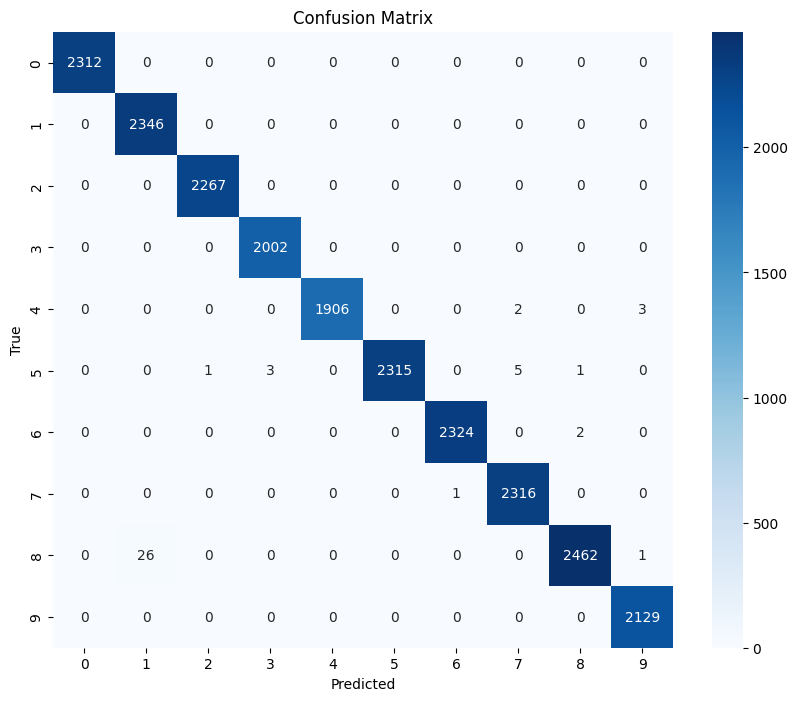

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Print Classification Report**

In [ ]:

target_names = list(val_dataset.class_to_idx.keys())
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

          c5       1.00      1.00      1.00      2312
          c3       0.99      1.00      0.99      2346
          c1       1.00      1.00      1.00      2267
          c7       1.00      1.00      1.00      2002
          c8       1.00      1.00      1.00      1911
          c6       1.00      1.00      1.00      2325
          c4       1.00      1.00      1.00      2326
          c2       1.00      1.00      1.00      2317
          c0       1.00      0.99      0.99      2489
          c9       1.00      1.00      1.00      2129

    accuracy                           1.00     22424
   macro avg       1.00      1.00      1.00     22424
weighted avg       1.00      1.00      1.00     22424



# **Write an Inference Function**
Now let's deploy the trained CNN model for inference on new images:

In [ ]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

# **Prepare Transform and Class Names**
Use the same transform as during training and get class names from dataset:

In [ ]:
class_names = list(dataset.class_to_idx.keys())

# **Load Model and Run Inference**

In [ ]:
model = SimpleCNN(num_classes=len(class_names))
model.load_state_dict(torch.load('driver_cnn_model.pth'))
model.to(device)

image_path = 'statefarm_data/imgs/train/c0/img_100026.jpg' # Example path to an image file
predicted_label = predict_image(image_path, model, transform, class_names)
print(f'Predicted Class: {predicted_label}')

Predicted Class: c0


# **Install Flask**
To set up a simple Flask API for real-time image classification with the PyTorch CNN model, install Flask:

In [ ]:
pip install Flask

# **Create a Flask App**
Save the following as app.py:

In [ ]:
from flask import Flask, request, jsonify
import torch
from torchvision import transforms
from PIL import Image
import io

app = Flask(__name__)

# Load model
model = SimpleCNN(num_classes=len(class_names))
model.load_state_dict(torch.load('driver_cnn_model.pth', map_location=torch.device('cpu')))
model.eval()

# Define transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = [...]  # list of class names as before

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'}), 400
    file = request.files['file']
    img_bytes = file.read()
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return jsonify({'predicted_class': predicted_class})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


# **Run the Flask App**

In [ ]:
%%writefile app.py
from flask import Flask, request, jsonify
import torch
from torchvision import transforms
from PIL import Image
import io
import os

app = Flask(__name__)

# Assuming SimpleCNN, class_names, transform are defined or imported elsewhere
# For standalone execution, these would need to be re-defined or loaded
# Let's re-define them for simplicity here assuming the context of the notebook

# Dummy class names for the app if not already defined
# In a real scenario, this would come from the trained model's dataset
# Ensure these match the ones used during training
class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'] # Example, retrieve from dataset.class_to_idx.keys()

# Define the SimpleCNN model class
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        # Calculate the size of the flattened features
        # For 128x128 input and 2 MaxPool2d layers (stride 2 each)
        # Image size becomes 128/2/2 = 32x32
        # Number of channels is 32
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(32 * 32 * 32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.classifier(x)
        return x

# Define transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load model (assuming 'driver_cnn_model.pth' exists)
model = SimpleCNN(num_classes=len(class_names))
model.load_state_dict(torch.load('driver_cnn_model.pth', map_location=torch.device('cpu')))
model.eval()

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'}), 400
    file = request.files['file']
    img_bytes = file.read()
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    input_tensor = transform(img).unsqueeze(0) # Add batch dimension

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return jsonify({'predicted_class': predicted_class})

if __name__ == '__main__':
    # Use 0.0.0.0 to make it accessible outside localhost in Colab
    app.run(host='0.0.0.0', debug=True)

Writing app.py


The API will listen on http://127.0.0.1:5000/predict. You can send POST requests with an image file to get predictions.

During running the program, it was observed that Kaggle Json file upload and the unzipped files went missing from the Colab environment due to long session idling or rest activities. We have included to re-run these steps again in the coding ahead to avoid complication of another long run-time if we start from the very beginning.

Let's get ahead with with client-side example code to POST images to this API or deployment tips and create a simple Python client to send an image file to your Flask prediction API:

In [ ]:
import requests
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# --- Start: Ensure dataset is available and unzipped for standalone execution ---
dataset_root = 'statefarm_data'
train_images_path = os.path.join(dataset_root, 'imgs', 'train')
zip_file_path = 'state-farm-distracted-driver-detection.zip'

if not os.path.exists(train_images_path):
    print(f"'{train_images_path}' not found. Attempting to prepare dataset...")

    # Ensure kaggle.json is available and setup if needed
    kaggle_config_dir = '/root/.kaggle/'
    kaggle_json_target_path = os.path.join(kaggle_config_dir, 'kaggle.json')

    # Check if kaggle.json exists in the target location
    if not os.path.exists(kaggle_json_target_path):
        print("kaggle.json not found at /root/.kaggle/. Checking current directory or prompting for upload.")

        # Check if kaggle.json exists in the current working directory
        if os.path.exists('kaggle.json'):
            print("Found kaggle.json in current directory. Moving it to /root/.kaggle/.")
            !mkdir -p {kaggle_config_dir}
            !mv kaggle.json {kaggle_config_dir}
            !chmod 600 {kaggle_json_target_path}
        else:
            # If not found anywhere, prompt the user to upload it
            print("kaggle.json not found. Please upload your kaggle.json file:")
            from google.colab import files
            uploaded = files.upload()
            if 'kaggle.json' in uploaded:
                print("kaggle.json uploaded. Moving it to /root/.kaggle/")
                !mkdir -p {kaggle_config_dir}
                with open(kaggle_json_target_path, 'wb') as f:
                    f.write(uploaded['kaggle.json'])
                !chmod 600 {kaggle_json_target_path}
            else:
                raise FileNotFoundError("kaggle.json was not uploaded. Cannot proceed with Kaggle download.")

    # Now that kaggle.json should be in place, proceed with download if zip file is missing
    if not os.path.exists(zip_file_path):
        print(f"Main dataset zip file '{zip_file_path}' not found. Downloading...")
        !kaggle competitions download -c state-farm-distracted-driver-detection
        if not os.path.exists(zip_file_path):
            raise FileNotFoundError(f"Failed to download '{zip_file_path}'. Please check Kaggle credentials and connectivity.")

    # Create dataset root if it doesn't exist
    if not os.path.exists(dataset_root):
        os.makedirs(dataset_root)

    # Unzip main archive
    print(f"Unzipping {zip_file_path} to {dataset_root}...")
    !unzip -q {zip_file_path} -d {dataset_root}

    # Unzip any inner zips if they exist
    for f in os.listdir(dataset_root):
        if f.endswith(".zip"):
            print(f"Unzipping inner archive: {f}")
            !unzip -q {os.path.join(dataset_root, f)} -d {dataset_root}

    if not os.path.exists(train_images_path):
         raise FileNotFoundError(f"Root directory '{train_images_path}' still does not exist after unzipping attempt. Check dataset structure.")
else:
    print(f"'{train_images_path}' already exists. Skipping dataset preparation.")
# --- End: Ensure dataset is available and unzipped ---

# Redefine DriverDataset, transform, and dataset for self-contained execution
class DriverDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Check if root_dir actually exists after unzipping attempt
        if not os.path.isdir(root_dir):
            raise FileNotFoundError(f"Root directory '{root_dir}' does not exist or is not a directory after unzipping attempt.")

        classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls in classes:
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                self.image_paths.append(os.path.join(cls_folder, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = DriverDataset(root_dir=train_images_path, transform=transform)

url = 'http://127.0.0.1:5000/predict'

# Get an actual image path from the successfully loaded dataset
image_path = dataset.image_paths[0] # Using the first image from the training dataset

with open(image_path, 'rb') as img_file:
    files = {'file': img_file}
    response = requests.post(url, files=files)

if response.status_code == 200:
    print("Predicted Class:", response.json()['predicted_class'])
else:
    print("Error:", response.text)

'statefarm_data/imgs/train' not found. Attempting to prepare dataset...
kaggle.json not found at /root/.kaggle/. Checking current directory or prompting for upload.
kaggle.json not found. Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
kaggle.json uploaded. Moving it to /root/.kaggle/
Main dataset zip file 'state-farm-distracted-driver-detection.zip' not found. Downloading...
100% 4.00G/4.00G [01:13<00:00, 109MB/s] 
100% 4.00G/4.00G [01:13<00:00, 58.1MB/s]
Unzipping state-farm-distracted-driver-detection.zip to statefarm_data...


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7b105e8e8f20>: Failed to establish a new connection: [Errno 111] Connection refused'))

How to Use
- Replace 'path_to_your_test_image.jpg' with the actual image path you want to test.

- Run this script to send the image to your Flask server and print the predicted class.

 Deploy the Flask app to a cloud service for making it production-ready with authentication and scalability.

 To deploy your Flask API with the CNN model on a cloud platform, here are common options and brief guidance:

# ***Cloud Deployment Options***
- **Heroku:** Simple PaaS for small apps. Just push your code via git, add a Procfile specifying how to run the app, and deploy. Supports GPU use with custom setups but mostly runs on CPU.

- **AWS Elastic Beanstalk:** Supports easy deployment of web apps with scalability. Use Amazon EC2 instances for GPU if necessary.

- **Google Cloud Run:** Container-based serverless platform. Package your app in a Docker container and deploy.

- **Azure App Service:** Similar cloud web app service, easy deployment with CI/CD pipelines.

# ***Key Deployment Steps***
1. Containerize the App (optional but recommended):

   - Use a Dockerfile to package your app, dependencies, and model.

2. Prepare requirements.txt

   - List all your Python dependencies (e.g., torch, flask, torchvision).

3. Create a Procfile (for platforms like Heroku)

   - Example: web: python app.py

4. Deploy

   - Use CLI or web console of the platform.

5. Manage Model Files

   - Either bundle model within the Docker image or load from external storage on start.

# ***Tips for Production Readyness***

- Use gunicorn or other WSGI servers instead of Flask's built-in server.

- Add authentication to your API.

- Monitor usage and scale instances as needed.

- Use HTTPS and secure credentials.



Let's now create a Dockerfile for this app with step-by-step instructions for one of these cloud providers.

Here's a simple Dockerfile example to containerize the Flask app with the PyTorch CNN model:

In [ ]:
# Use official Python image as base
FROM python:3.9-slim

# Set working directory
WORKDIR /app

# Copy requirement files and install dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy all app files
COPY . .

# Expose the port Flask will run on
EXPOSE 5000

# Command to run the app with gunicorn for better performance
CMD ["gunicorn", "--bind", "0.0.0.0:5000", "app:app"]

Additional Files Needed:
requirements.txt

In [ ]:
flask
torch
torchvision
Pillow
gunicorn

# **Build and Run the Docker Container**


In [ ]:
# Build image with tag
docker build -t distracted-driver-cnn .

# Run container (map port 5000)
docker run -p 5000:5000 distracted-driver-cnn

 The Flask API will then be accessible at http://localhost:5000.

Let's now go for the detailed instructions for deploying this Docker container to a cloud platform like AWS, Google Cloud, or Heroku.

I have chosen Heroku:
# **Step 1: Install Heroku CLI**
Download and install from https://devcenter.heroku.com/articles/heroku-cli

# **Step 2: Login to Heroku**


In [ ]:
heroku login

# **Step 3: Create a Heroku App**

In [ ]:
heroku create your-app-name

# **Step 4: Add a Procfile**

In your project directory, create a file named Procfile with:



In [ ]:
web: gunicorn app:app

# **Step 5: Initialize Git and Commit Code**


In [ ]:
git init
git add .
git commit -m "Initial commit"

# **Step 6: Set Heroku Stack to Container**

In [ ]:
heroku stack:set container -a your-app-name

# **Step 7: Create a heroku.yml for Docker deployment**

Create heroku.yml in your project root:

In [ ]:
build:
  docker:
    web: Dockerfile

run:
  web: gunicorn app:app

# **Step 8: Deploy to Heroku**




In [ ]:
git push heroku master


or if using main branch

In [ ]:
git push heroku main


# **Step 9: Open Your App**


In [ ]:
heroku open


The Flask CNN API should now be live.



In [ ]:
!python app.py &

Traceback (most recent call last):
  File "/content/app.py", line 57, in <module>
    model.load_state_dict(torch.load('driver_cnn_model.pth', map_location=torch.device('cpu')))
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 1484, in load
    with _open_file_like(f, "rb") as opened_file:
         ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 759, in _open_file_like
    return _open_file(name_or_buffer, mode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 740, in __init__
    super().__init__(open(name, mode))
                     ^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'driver_cnn_model.pth'


# **Start of - Bhavin Implemented YoLo Model based Training & Test Below**

In [5]:
%%capture --no-display
!pip install ultralytics
!pip install split-folders
!pip install -U ipywidgets

In [6]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import splitfolders
from IPython.display import display, Image
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [19]:
#model = YOLO('yolov8n-cls.pt')

model = YOLO('yolo11n-cls.pt')

In [20]:
splitfolders.ratio("statefarm_data/imgs/train", output="statefarm_data/output", seed=1337, ratio=(0.7, 0.15, 0.15))

Copying files: 22424 files [00:08, 2554.65 files/s]


In [21]:
results = model.train(data = 'statefarm_data/output', epochs = 10)

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=statefarm_data/output, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

In [22]:
model.val()

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,538,834 parameters, 0 gradients, 3.2 GFLOPs
train: /content/statefarm_data/output/train... found 15692 images in 10 classes ✅ 
val: /content/statefarm_data/output/val... found 3358 images in 10 classes ✅ 
test: /content/statefarm_data/output/test... found 3374 images in 10 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1535.8±606.0 MB/s, size: 40.3 KB)
val: Scanning /content/statefarm_data/output/val... 3358 images, 0 corrupt: 100% ━━━━━━━━━━━━ 3358/3358 6.8Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 210/210 11.1it/s 18.9s
                   all      0.996          1
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec5d3e5fd40>
curves: []
curves_results: []
fitness: 0.9982132315635681
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9964264631271362, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9982132315635681}
save_dir: PosixPath('/content/runs/classify/val')
speed: {'preprocess': 0.10094167927430944, 'inference': 1.0297518546751685, 'loss': 0.0013295801072390797, 'postprocess': 0.0009496670623015041}
task: 'classify'
top1: 0.9964264631271362
top5: 1.0

In [23]:
df = pd.read_csv("runs/classify/train/results.csv")
df.head(5)

epoch     time  train/loss  metrics/accuracy_top1  metrics/accuracy_top5  \
0      1  158.114     1.08291                0.95205                0.99792   
1      2  312.793     0.34202                0.96873                0.99940   
2      3  466.979     0.25854                0.97588                0.99940   
3      4  621.974     0.21306                0.98362                0.99970   
4      5  772.423     0.16532                0.98749                1.00000   

   val/loss    lr/pg0    lr/pg1    lr/pg2  
0   0.17015  0.000238  0.000238  0.000238  
1   0.09274  0.000429  0.000429  0.000429  
2   0.07341  0.000572  0.000572  0.000572  
3   0.04804  0.000502  0.000502  0.000502  
4   0.03908  0.000431  0.000431  0.000431

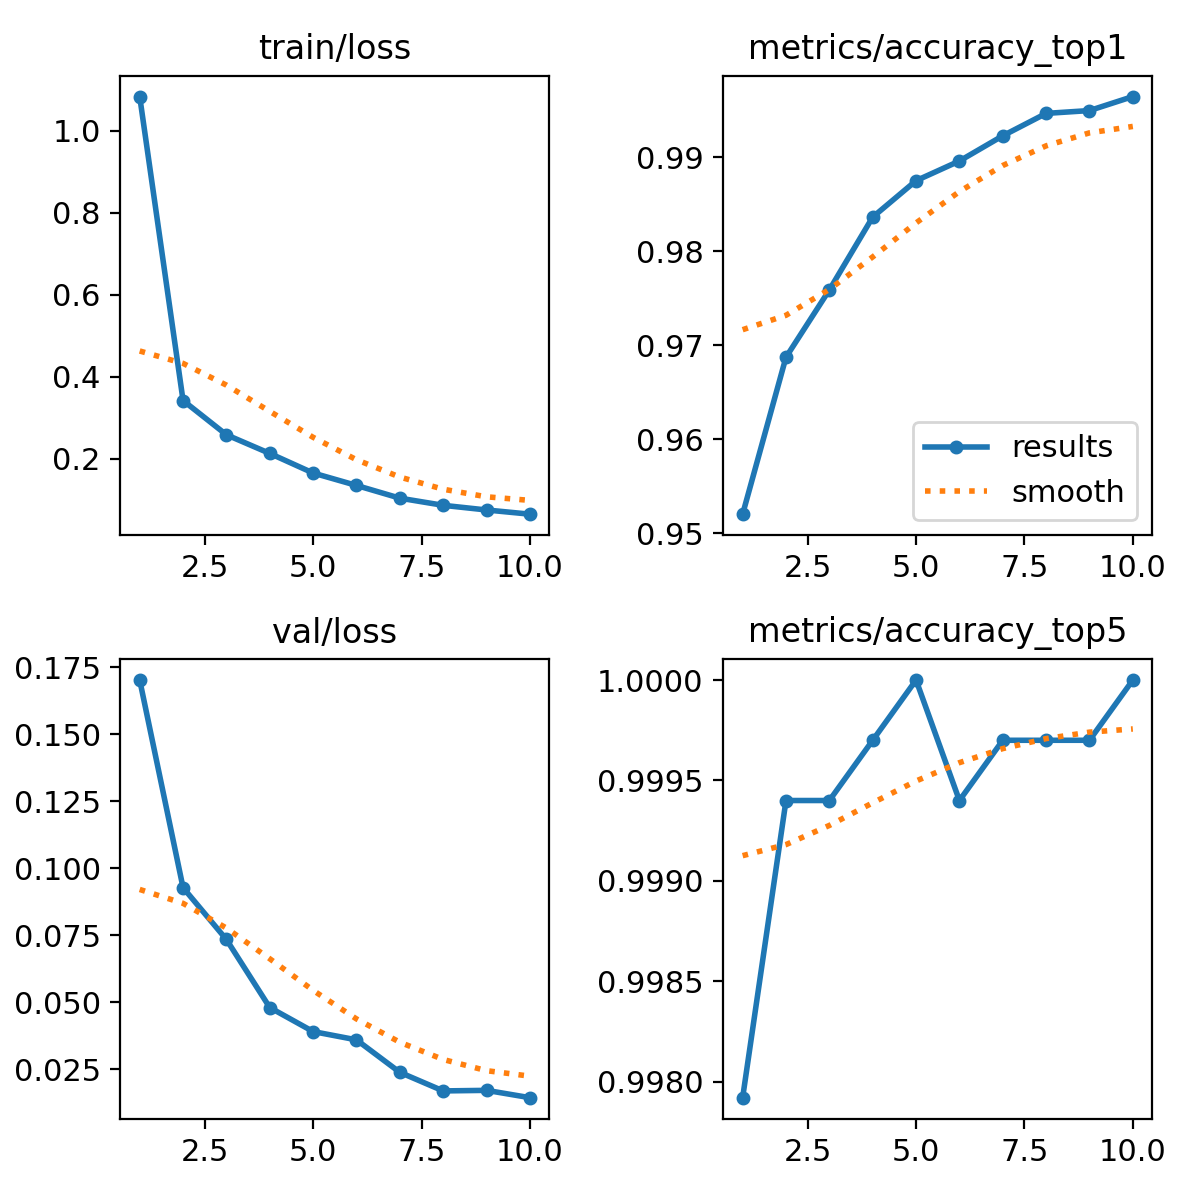

In [24]:
Image("runs/classify/train/results.png")

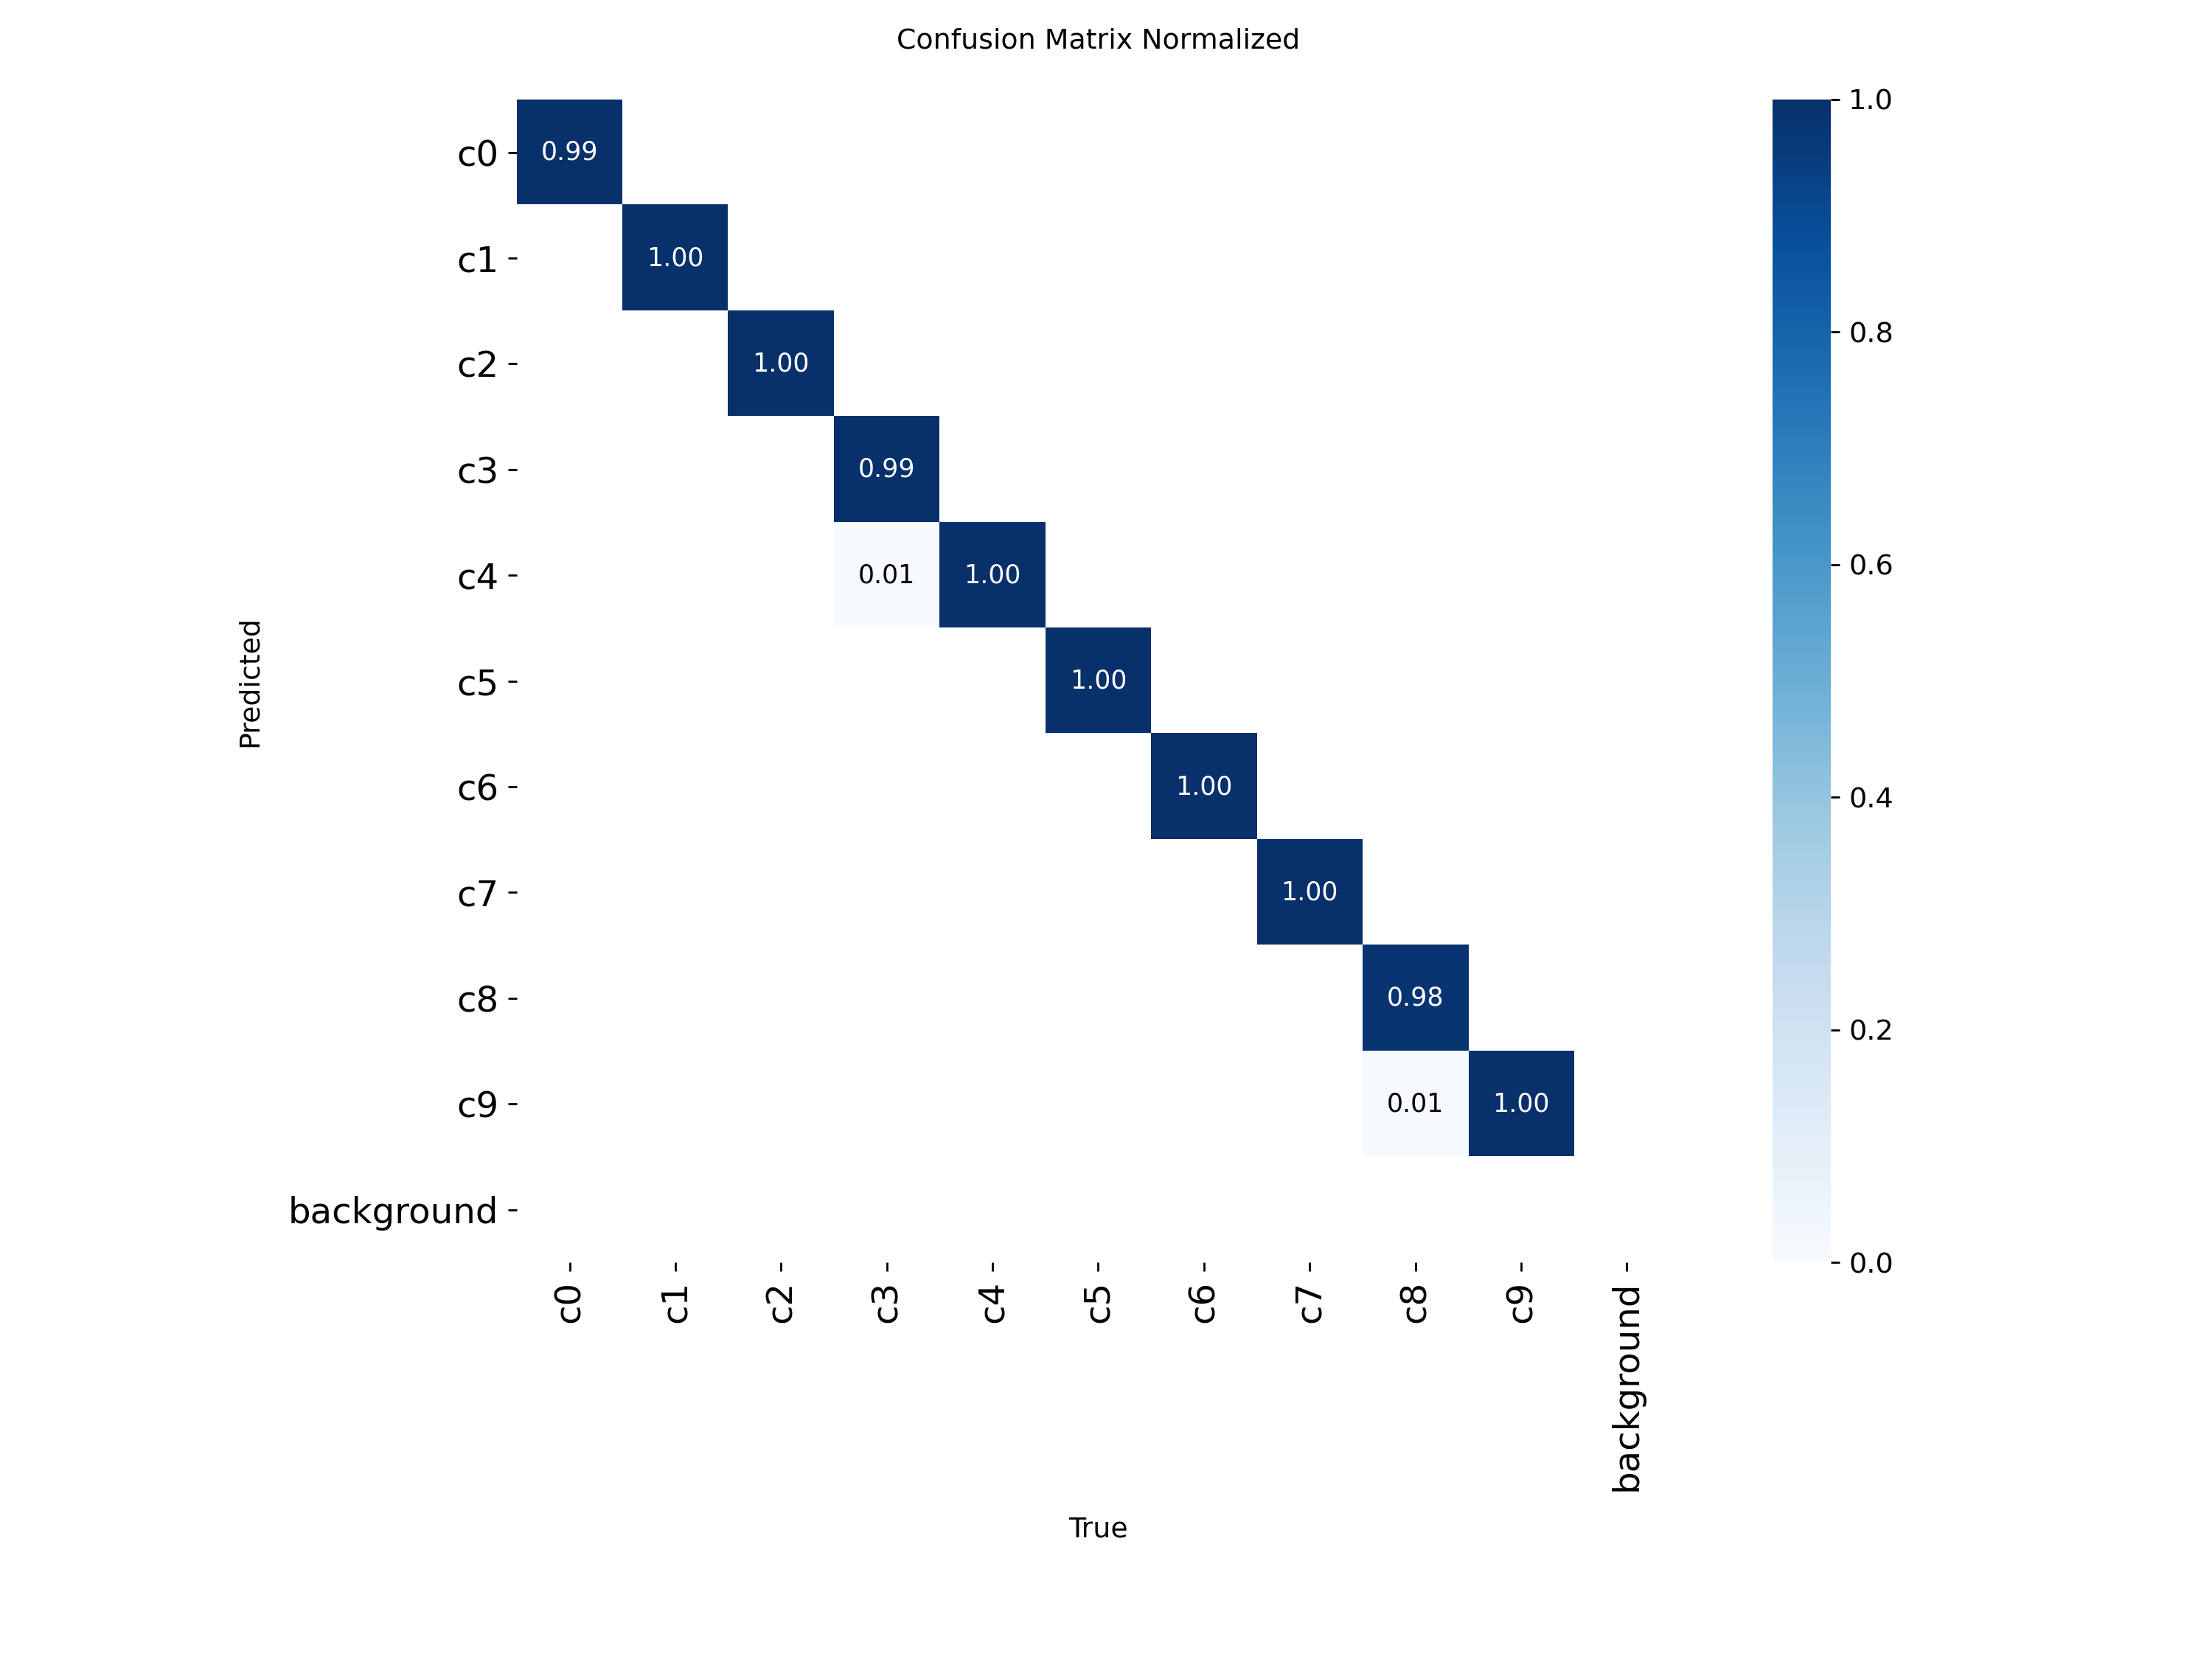

In [25]:
Image("runs/classify/train/confusion_matrix_normalized.png")

In [26]:
path = "statefarm_data/imgs/test/"
model_weights = "/statefarm_data/working/runs/classify/train/weights/best.pt"
pred = [(path+i,model.predict(path+i, model = model_weights)[0].probs.top1) for i in os.listdir(path)[:45]]


image 1/1 /content/statefarm_data/imgs/test/img_14409.jpg: 224x224 c4 1.00, c9 0.00, c8 0.00, c6 0.00, c3 0.00, 4.4ms
Speed: 6.6ms preprocess, 4.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/statefarm_data/imgs/test/img_11573.jpg: 224x224 c2 1.00, c5 0.00, c6 0.00, c8 0.00, c1 0.00, 4.0ms
Speed: 4.7ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/statefarm_data/imgs/test/img_55171.jpg: 224x224 c9 0.83, c7 0.11, c8 0.06, c0 0.00, c4 0.00, 3.7ms
Speed: 4.0ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/statefarm_data/imgs/test/img_66048.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c4 0.00, c9 0.00, 3.7ms
Speed: 3.9ms preprocess, 3.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/statefarm_data/imgs/test/img_38737.jpg: 224x224 c1 1.00, c8 0.00, c9 0.00, c6 0.00, c7 0.00, 3.5ms
Speed: 3.7ms preproce

In [27]:
labels = {
    0: 'normal driving',
1: 'texting - right',
2: 'talking on the phone - right',
3: 'texting - left',
4: 'talking on the phone - left',
5: 'operating the radio',
6: 'drinking',
7: 'reaching behind',
8: 'hair and makeup',
9: 'talking to passenger'}

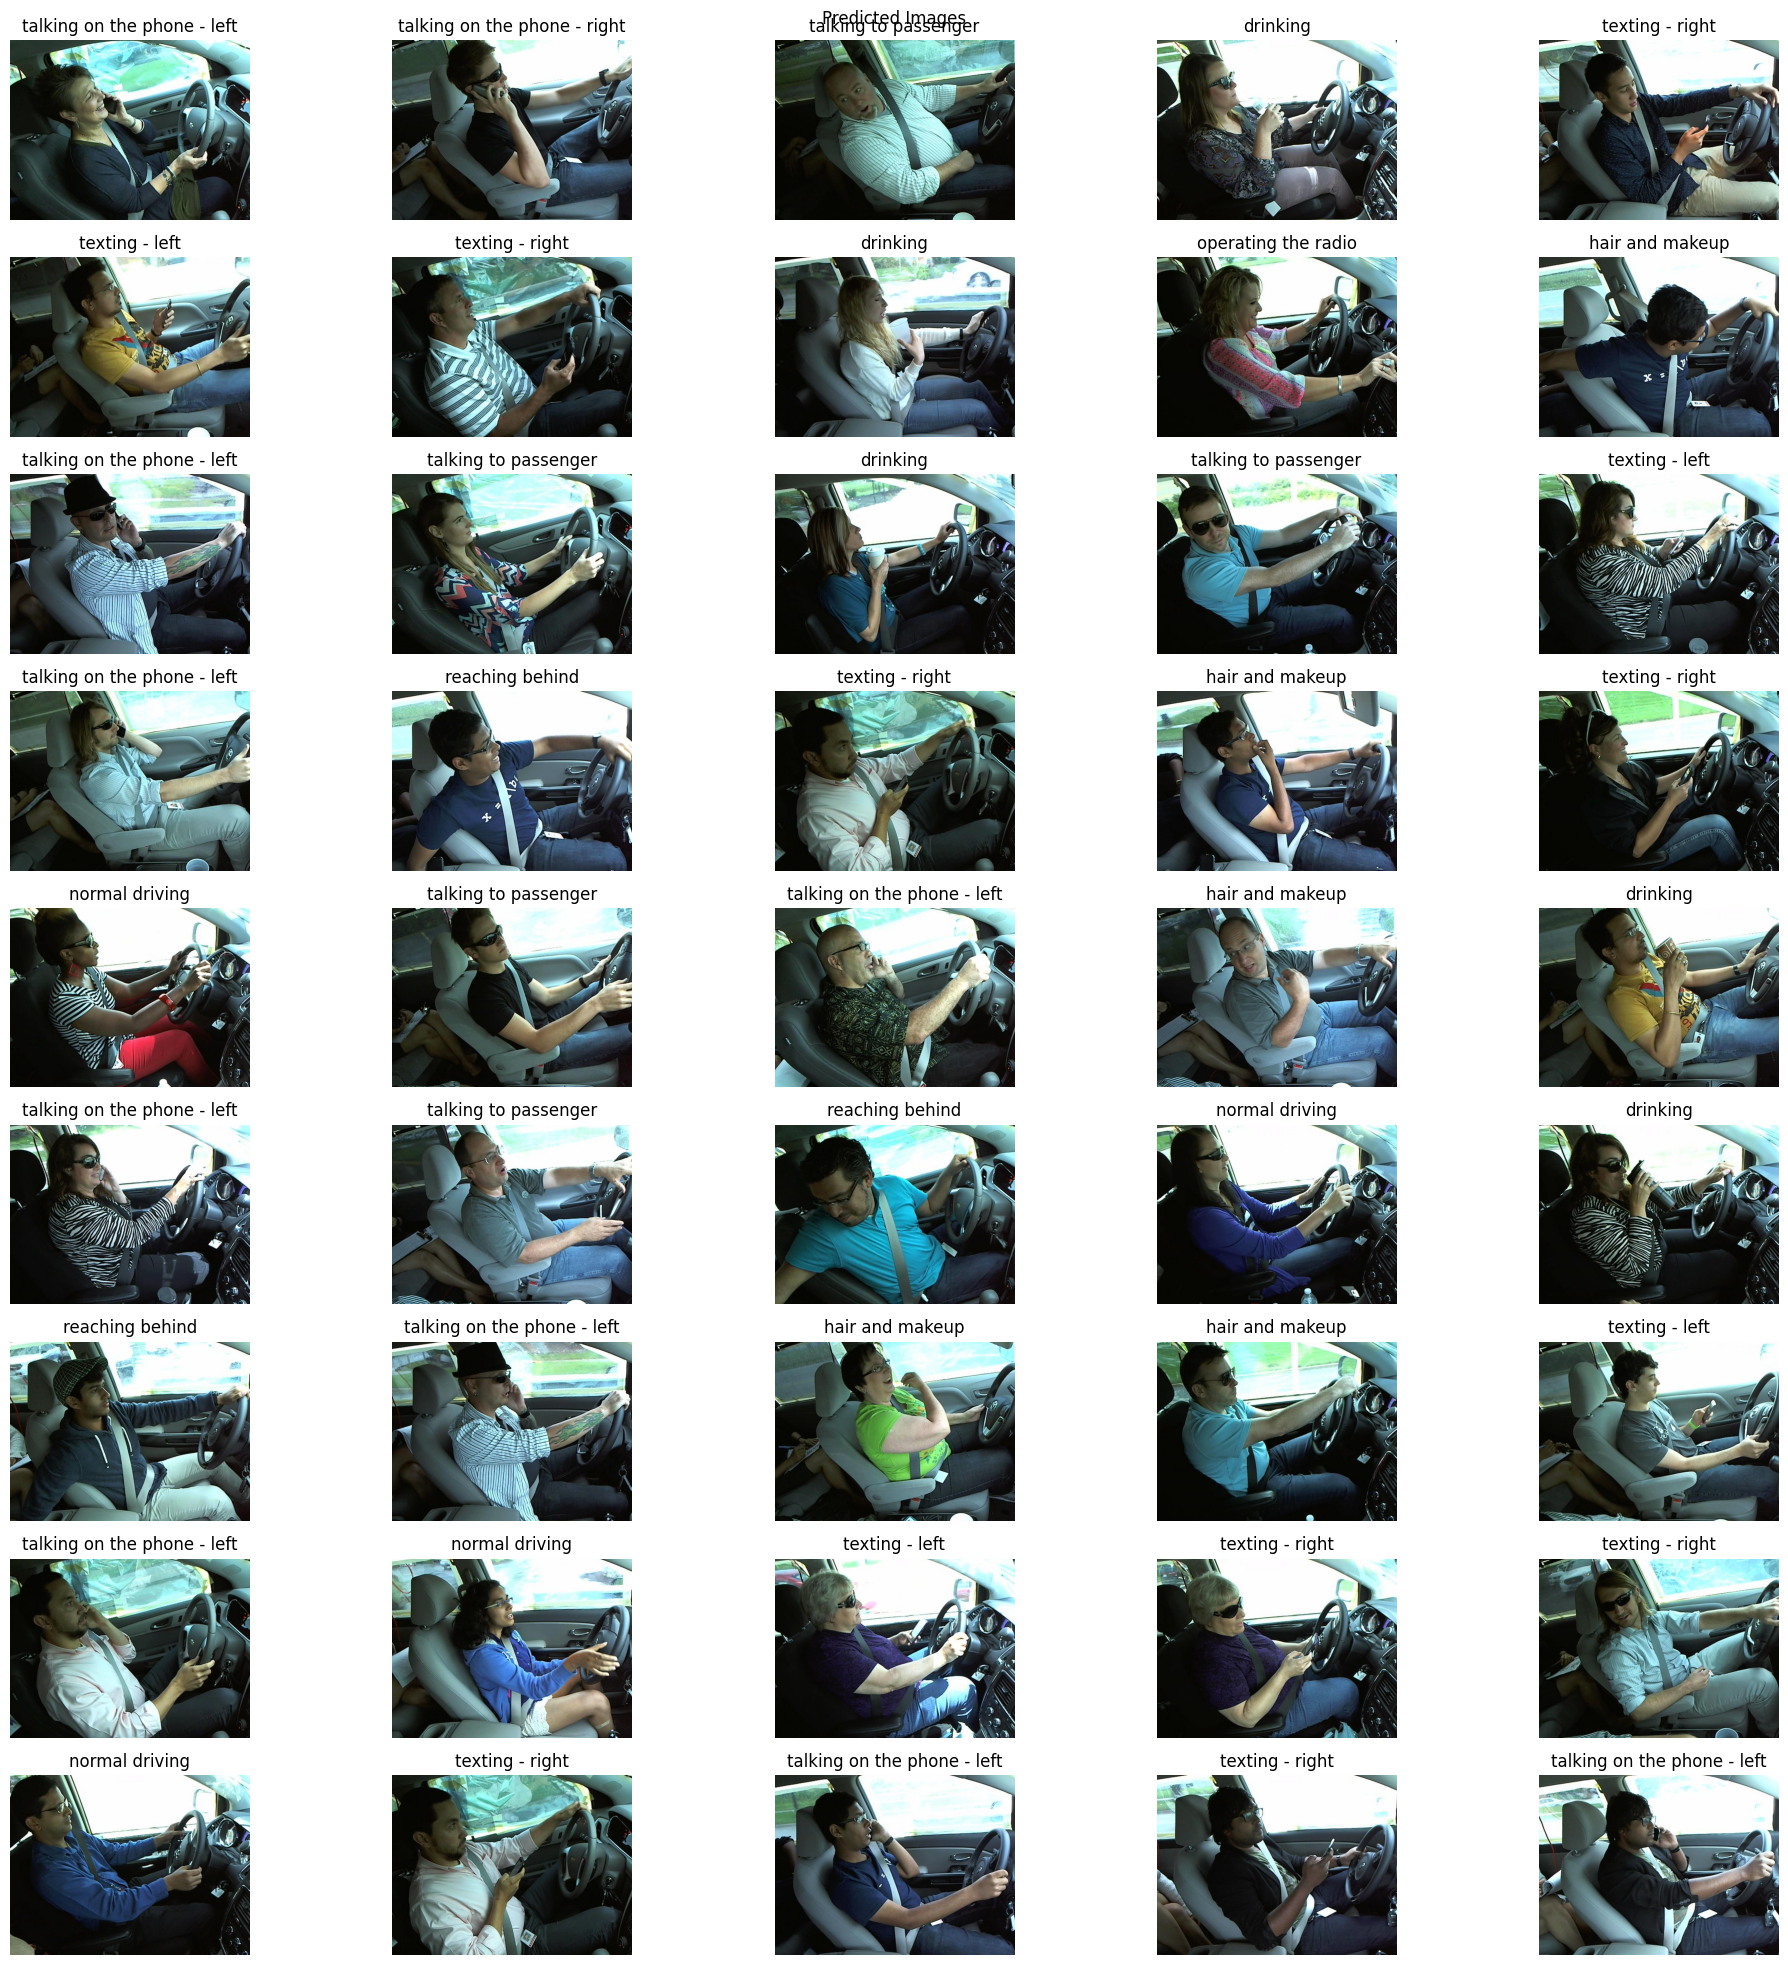

In [28]:
rows = 9
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
for i, (img, label) in enumerate(pred):
    row = i // cols
    col = i % cols
    ax[row, col].imshow(plt.imread(img))
    ax[row, col].set_title(labels.get(label))
    ax[row, col].axis('off')

plt.suptitle("Predicted Images")
plt.tight_layout()
plt.show()

# **End of - Bhavin Implemented YoLo Model based Training & Test Below**